# Accessing Information in Quarterly Earnings Conference Calls: A Text Mining based Analysis

The goal of this project is to evaluate the the sentiment expressed in earning conference calls' transcripts of companies included in the Dow Jones Industrial Average index.
The sample of textual data used in project were published by Thomson Reuters StreetEvents. 

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [254]:
%cd drive/My Drive/Colab Notebooks/Conference_Calls

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Conference_Calls'
/content/drive/My Drive/Colab Notebooks/Conference_Calls


In [255]:
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import pandas as pd
import numpy as np
import re
import datetime
import operator as op
from os import listdir
import seaborn as sns

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Creating a table with sentiment values for all conference calls

## 1.1 Loading the text documents

The transcripts are stored in a folder called 'data'.
First we list all documents in this folder and store it as a list with the name 'document_names'.

In [307]:
document_names = list(listdir('data/'))

In [308]:
# show a random name of an element in the list
print(document_names[np.random.randint(0,len(document_names))])

INTC-Transcript-2009-07-14T21_30.txt


Load all documents listed in document_names and create a list called documents.

In [309]:
documents = []
for document_name in document_names:        
    with open('data/'+document_name, 'r', errors='ignore') as l:
        document = l.read()
        documents.append(document)

In [310]:
# show 2000 caracters in the middle of a randomly choosen transcript
print(documents[np.random.randint(0,len(documents))][int(len(documents[0])/2)-1000:int(len(documents[0])/2)+1000])

t with the impact, I don't know that I can give you a number. Matt, do you have anything recorded there?

--------------------------------------------------------------------------------
 Matt Ginter,  3M Company - VP of IR   [4]
--------------------------------------------------------------------------------
 Estimate, George.

--------------------------------------------------------------------------------
 George Buckley,  3M Company - Chairman, Pres, CEO   [5]
--------------------------------------------------------------------------------
 So it has been positive, John, obviously, but very difficult to give you a precise number. Can we make an estimate and get back to you.

--------------------------------------------------------------------------------
 John Inch,  Merrill Lynch - Analyst   [6]
--------------------------------------------------------------------------------
 For sure. Just as a follow-up, I know that at the December 12th meeting we had thrown out currency contrib

## 1.2 Extracting host companys name and ISIN 

First, we load two dictionaries containing the names and ISINs.

In [ ]:
# Appreviation to company name dict
name_dict = {'AA': 'Alcoa Corporation',
             'AXP': 'American Express Co',
             'BA': 'Boeing Co',
             'CAT':'Caterpillar Inc',
             'CSCO': 'Cisco Systems Inc',
             'CVX': 'Chevron Corp',
             'DD' : 'DuPont',
             'DWDP' : 'DuPont',
             'DIS': 'Walt Disney Co',
             'GE' : 'General Electric Co',
             'GS' : 'Goldman Sachs Group Inc',
             'HD' : 'Home Depot Inc',
             'HPQ' : 'Hewlett-Packard Co',
             'IBM' : 'International Business Machines Corp',
             'INTC' : 'Intel Corp',
             'JNJ' : 'Johnson & Johnson',
             'JPM' : 'JPMorgan Chase & Co',
             'KO': 'Coca-Cola Co',
             'MCD' : 'McDonalds Corp',
             'MMM':'3M Co',
             'MRK' : 'Merck & Co Inc',
             'MSFT' : 'Microsoft Corp',
             'NKE' : 'Nike Inc',
             'PFE' : 'Pfizer Inc',
             'PG' : 'Procter & Gamble Co',
             'TRV' : 'Travelers Companies Inc',
             'T': 'AT&T Inc',
             'UNH' : 'UnitedHealth Group Inc',
             'UTX' : 'United Technologies Corp',
             'V' : 'Visa Inc',
             'VZ' : 'Verizon Communications Inc',
             'WMT' : 'Wal-Mart Stores Inc',
             'XOM' : 'Exxon Mobil Corp'
             }

# Company name to ISIN
id_dict = { 'Alcoa Corporation' : 'US0138721065',
            'American Express Co' : 'US0258161092',
            'Boeing Co' : 'US0970231058',
            'Caterpillar Inc' : 'US1491231015',
            'Cisco Systems Inc' : 'US17275R1023',
            'Chevron Corp' : 'US1667641005',
            'DuPont' : 'US26078J1007',
            'Walt Disney Co' : 'US2546871060',
            'General Electric Co' : 'US3696041033',
            'Goldman Sachs Group Inc' : 'US38141G1040',
            'Home Depot Inc' : 'US4370761029',
            'Hewlett-Packard Co' : 'US42824C1099',
            'International Business Machines Corp' : 'US4592001014',
            'Intel Corp' : 'US4581401001',
            'Johnson & Johnson' : 'US4781601046',
            'JPMorgan Chase & Co' : 'US46625H1005',
            'Coca-Cola Co' : 'US1912161007',
            'McDonalds Corp' : 'US5801351017',
            '3M Co' :'US88579Y1010',
            'Merck & Co Inc' : 'US58933Y1055',
            'Microsoft Corp' : 'US5949181045',
            'Nike Inc' : 'US6541061031',
            'Pfizer Inc' : 'US7170811035',
            'Procter & Gamble Co' : 'US7427181091',
            'Travelers Companies Inc' : 'US89417E1091',
            'AT&T Inc' : 'US00206R1023',
            'UnitedHealth Group Inc' : 'US91324P1021',
            'United Technologies Corp' : 'US9130171096',
            'Visa Inc' : 'US92826C8394',
            'Verizon Communications Inc' : 'US92343V1044',
            'Wal-Mart Stores Inc' : 'US9311421039',
            'Exxon Mobil Corp' : 'US30231G1022' 
            }

Then function 'get_name(document)' uses regular expressions to identify and extract the abbreviation for a company name in each document. 
Then it uses the dictionaries to translate the abbreviation to the company name and isin.

Example of the abbreviation in the text:


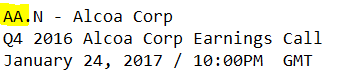

In [ ]:
def get_name(document):

    # Identify the abbreviation in the document
    abbrev = re.findall(r'E D I T E D   V E R S I O N\n\n[A-Z]+',document)
    abbrev = str(abbrev[0]).split('\n\n')
    abbrev = abbrev[1]
    
    # Translate the abbreviation to the company name using the dictionary 'name_dict'
    company_name = name_dict[abbrev]

    # Translate the company name to the ISIN using the dictionary 'id_dict'
    company_id = id_dict[company_name]
        
    # Return the name of the company and its ISIN
    return company_name, company_id

## 1.3 Extracting the time and date of the call from the document

The function get_date_time is created to use regular expressions to extract the date and time of a conference call from the documents. 
For example:

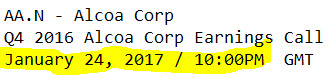


In [ ]:
def get_date_time(document):
    
    # Identify date pattern (month dd, yyyy / hh:mm(AM/PM)) in document and split the digits in a list
    pattern = re.findall(r'\w+ \d{2}, \d{4} \/ \d{2}:\d{2}\w+', document)
    pattern = str(pattern[0]).replace(':', ' ').replace('/ ','').replace('AM', ' AM').replace('PM', ' PM').replace(',','')
    pattern_list = pattern.split(' ')

    # Create a datetime object with the previously created list
    date_time = datetime.datetime.strptime(str(pattern_list[0])+' '+str(pattern_list[1])+' '+str(pattern_list[2])+' '+str(pattern_list[3])+' '+str(pattern_list[4])+' '+str(pattern_list[5]), '%B %d %Y %I %M %p')
        
    # Return tuple with the date and time
    return (date_time.time(), date_time.date())

## 1.4 Extracting the different sections of the conference call 

The documents contain more text than only the transcript (eg. date, time, Disclaimer,...). Since we only want to analyze the sentiment of the trascript itself, we need to extract the transcript from the rest of the document.
The function 'extract_transcript(document)' does so by splitting the documents when key words appear that mark the beginning or and of the transcript. Since the text is stored in a semi-structered form the word, this can be done using regular expressions again.

In [ ]:
def extract_transcript(document):

    # Change the whole document to lowercase letters
    document = document.lower()

    # Check whether text has beginning, end and Q&A-session
    if re.findall('\npresentation\n', document) != []:
        document = document.split('\npresentation\n')
        if re.findall("\ndefinitions\n", document[1]) != []:
            document = document[1].split("\ndefinitions\n")
            transcript = document[0]
        else:
            transcript = ''
    else:
        transcript = ''
    return transcript

Now, we split the transcript it the two main sections, the presentation at the beginning and the questions and answers session.

In [ ]:
def extract_presentation_qanda(transcript):
    transcript = transcript.lower()
    if re.findall("\nquestions and answers\n", transcript) != []:
        transcript = transcript.split("\nquestions and answers\n")
        presentation = transcript[0]
        qanda = transcript[1]
    else:
        presentation = ''
        qanda = ''

    return presentation, qanda

Now we want to seperate the questions of analysts from the answers of corporate representatives. It might be interesting to see how the sentiment exprest by the analysts differs from the one exprest by the representatives.

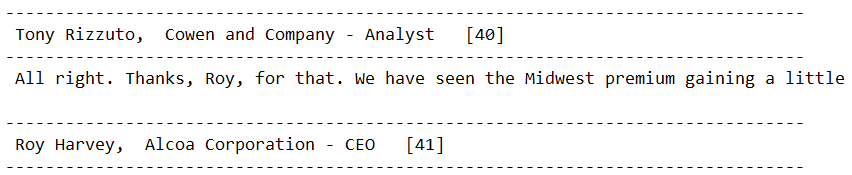

As you can see on the picture, representatives have the name of the company written next to their name in the section showing who is speaking next.
The name written here is not always identical to the official company name. Therfore, we need another dictionary to look for the correct names in the text. 

In [ ]:
corporate = {'Alcoa Corporation':'alcoa',
             'American Express Co':'express',
             'Boeing Co' : 'boeing',
            'Caterpillar Inc' : 'caterpillar',
            'Cisco Systems Inc' : 'cisco',
            'Chevron Corp' : 'chevron',
            'DuPont' : 'dupont',
            'Walt Disney Co' : 'walt',
            'General Electric Co' : 'electric',
            'Goldman Sachs Group Inc' : 'goldman',
            'Home Depot Inc' : 'home',
            'Hewlett-Packard Co' : 'kein weiterer name',
            'International Business Machines Corp' : 'kein weiterer name',
            'Intel Corp' : 'intel',
            'Johnson & Johnson' : 'johnson &',
            'JPMorgan Chase & Co' : 'morgan',
            'Coca-Cola Co' : 'cola',
            'McDonalds Corp' : 'mcdonald',
            '3M Co' :'3m',
            'Merck & Co Inc' : 'merck',
            'Microsoft Corp' : 'microsoft',
            'Nike Inc' : 'nike',
            'Pfizer Inc' : 'pfizer',
            'Procter & Gamble Co' : 'procter',
            'Travelers Companies Inc' : 'travelers',
            'AT&T Inc' : 'at&t',
            'UnitedHealth Group Inc' : 'unitedhealth',
            'United Technologies Corp' : 'technologies',
            'Visa Inc' : 'visa',
            'Verizon Communications Inc' : 'verizon',
            'Wal-Mart Stores Inc' : 'mart ',
            'Exxon Mobil Corp' : 'exxon'}

The function get_q_and_a(qanda, institute, conference) gets as arguments the previously extracted Q&A section, the name of the institute, and the document name of the conference call.

It looks for the described name patterns and based on that categorizes the role of the person speaking as operator, corporate representative, analyst, and unknown.

In [ ]:
def get_q_and_a(qanda, institute, conference):
    if qanda != '':
        qanda = re.sub('\-{6,}','****',qanda)  # replace all '-' more += 6 with '****'
        qanda = re.sub(']\n\*+',']\n**',qanda) # differenciate between beginning of text and name
        qanda = qanda.strip()
        qanda = qanda.split('***') # split the text in the different identified blocks
        qanda = qanda[1:-3]   # skip first and last element because they are empty
        role = []
        person = []
        text = []
        
        for i in range(len(qanda)):
            qanda[i] = re.sub('\n','',qanda[i])
            qanda[i] = qanda[i].split('**')     # split name and text qa[i][0] = name, qa[i][1] = text
            if (institute == 'International Business Machines Corp') & (re.findall(r'\*\D+(machines|ibm)+\D+\d+\]', qanda[i][0]) != []):
                role.append('corporate_representative')
            elif (institute == 'Hewlett-Packard Co')& (re.findall(r'\*\D+(hewlett|hp)+\D+\d+\]', qanda[i][0]) != []):
                role.append('corporate_representative')
            elif re.findall(r'\*\D+(corporate|'+corporate[institute]+')+\D+\d+\]', qanda[i][0]) != []:
                role.append('corporate_representative')
            elif (re.findall(r'\*\D?opera\D+\d+\]', qanda[i][0]) != []):
                role.append('operator') 
            elif (re.findall(r'\*\D?unident\D+\d+\]', qanda[i][0]) != []) | (re.findall(r'\*\D?indiscernible\D+\d+\]', qanda[i][0]) != []): 
                role.append('unidentified')
            else:
                role.append('analyst') 
            qanda[i][0] = re.sub('\* ?','', qanda[i][0])
            qanda[i][0] = re.sub('\ +\[\d+\]','', qanda[i][0])
            qanda[i][0] = qanda[i][0].strip(',')
            qanda[i][1] = qanda[i][1].strip()
            text.append(qanda[i][1])
            person.append(qanda[i][0])

        df = pd.DataFrame({'role': role, 'person' : person, 'text': text, 'conference': conference})
    else:
        df = pd.DataFrame(columns={'role', 'person', 'text', 'conference'})
    return df

## 1.5 Tokenizing

Now the sections of the transcript are tokenized into separate words. This step is required to allow a comparison between the single worlds and the sentiment dictionaries. 

In [ ]:
def preprocessing(transcript):
    transcript = word_tokenize(transcript)                                # Splits the text in a list of single words
    transcript = [word for word in transcript if len(word) > 1]           # Sort out strings smaller len(1)
    
    return transcript

## 1.6 Importing the sentiment dictionaries

We import different dictionaries and convert them into numpy arrays. This facilitates later the comparison. 

We use the following dictionaries:

1.
General Inquirer. “The General Inquirer Home Page,” March 25, 2019 (http://www.wjh.harvard.edu/~inquirer/Home.html).

2.
Henry, E. 2008. “Are Investors Influenced By How Earnings Press Releases Are Written?” Journal of Business Communication (45:4), pp. 363–407.

3.
Loughran, T., and McDonald, B. 2011. “When Is a Liability Not a Liability? Textual Analysis, Dictionaries, and 10-Ks,” The Journal of Finance (66:1).

In [ ]:
# Import Harvard Sentiment Dictionary as Pickle
h_dict = pd.read_pickle('Harvard_Dict')

# Create positive word list as array
h_dict_pos = h_dict[h_dict['Positiv'] == 1]  
h_dict_pos = np.array(h_dict_pos['Entry'].apply(lambda x: x.lower()))

# Create negatice word list as array
h_dict_neg = h_dict[h_dict['Negativ'] == 1]  
h_dict_neg = np.array(h_dict_neg['Entry'].apply(lambda x: x.lower()))

In [ ]:
# Import Henry Dictionary as Pickle
hen_dict = pd.read_pickle('Henry')

# Create positive word list as array
hen_dict_pos = hen_dict[hen_dict['sent'] == 1]
hen_dict_pos = np.array(hen_dict_pos['word'])

# Create negatice word list as array
hen_dict_neg = hen_dict[hen_dict['sent'] == 0]
hen_dict_neg = np.array(hen_dict_neg['word'])

In [ ]:
# Import Loughran and McDonald Dictionary from Excel
lm_dict = pd.read_excel('L&MD.xlsx')

# Create positive word list as array
lm_dict_pos = np.array(lm_dict['Fin-pos'].dropna().apply(lambda x: x.lower()))

# Create negative word list as array
lm_dict_neg = np.array(lm_dict['Fin-neg'].apply(lambda x: x.lower()))

## 1.7 Extract Sentiment
To evaluate the sentiment in a conference call, the number of of positive and negative **opinion words** in each section of the ranscript needs to be counted.

While doing so, a simple **negation rule** is applied: If one of the three words preceding a string matching with the dictionary was ‘no’, ‘not’, ‘none’, ‘neither’, ‘never’ or ‘nobody’, the sentiment implied by the opinion word´s occurrence negated. The sum of positive (negative) opinion words and the negation of negative (positive) opinion words in the j-th earnings conference call transcript is defined as Positive𝑗 (𝑁𝑒𝑔𝑎𝑡𝑖𝑣𝑒𝑗).


In [314]:
def get_pos_neg(transcript):
    
    h_pos, h_neg, hen_pos, hen_neg, lm_pos, lm_neg = 0, 0, 0, 0, 0, 0
    
    negation_words = np.array(['no', 'not', 'none', 'neither', 'never', 'nobody'])
    
    for i, w in enumerate(transcript):    
        
        if (w in h_dict_pos) | (w in h_dict_neg) | (w in hen_dict_pos) | (w in hen_dict_neg) | (w in lm_dict_pos) | (w in lm_dict_neg):
            
            # Check for negation
            negation = False
            if (transcript[i-3] in negation_words) | (transcript[i-2] in negation_words) | (transcript[i-1] in negation_words):
                negation = True
                
            # Positive Harvard Dictionary
            if ((w in h_dict_pos) & (negation == False)) | ((w in h_dict_neg) & (negation == True)):
                h_pos += 1
            
            # Negative Harvard Dictionary
            if ((w in h_dict_neg) & (negation == False)) | ((w in h_dict_pos) & (negation == True)):
                h_neg += 1
            
            # Positive Henry Dictionary
            if ((w in hen_dict_pos) & (negation == False)) | ((w in hen_dict_neg) & (negation == True)):
                hen_pos += 1
            
            # Negative Henry Dictionary
            if ((w in hen_dict_neg) & (negation == False)) | ((w in hen_dict_pos) & (negation == True)):
                hen_neg += 1
            
            # Positive LMD Dictionary
            if ((w in lm_dict_pos) & (negation == False)) | ((w in lm_dict_neg) & (negation == True)):
                lm_pos += 1
            
            # Negative Henry Dictionary
            if ((w in lm_dict_neg) & (negation == False)) | ((w in lm_dict_pos) & (negation == True)):
                lm_neg += 1


    # return tupel with different TONE values for harvard, henry and LM   
    return (h_pos, h_neg, hen_pos, hen_neg, lm_pos, lm_neg)

The **relation between positive and negative opinion words** expressed in the j-th earnings conference call is described with the variable **𝑇𝑂𝑁𝐸𝑗** which represents the sentiment expressed. 

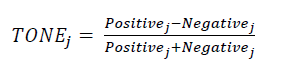


In [ ]:
def get_tone(h_pos, h_neg, hen_pos, hen_neg, lm_pos, lm_neg):
    h_tone = 0
    hen_tone = 0
    lm_tone = 0
    
    if (h_pos + h_neg) > 0:
        h_tone = (h_pos-h_neg)/(h_pos+h_neg)
    if (hen_pos + hen_neg) > 0:
        hen_tone = (hen_pos -hen_neg)/(hen_pos + hen_neg)
    if (lm_pos+lm_neg) > 0:
        lm_tone = (lm_pos - lm_neg)/(lm_pos+lm_neg)
    return h_tone, hen_tone, lm_tone

## 1.8 Use the introduced functions to create the sentiment and Q&A table 

The function *create_sentiment_and_qanda_tables(documents)* receives the documents and creates the sentiment and Q&A tables with all the functions we have used to far.

In [ ]:
def create_sentiment_and_qanda_tables(documents):
    sentiment_table = pd.DataFrame(columns=['document','institute', 'isin', 'date', 'time', 'h_tone_total', 'hen_tone_total', 'lm_tone_total', 'h_tone_presentation', 'hen_tone_presentation', 'lm_tone_presentation', 'h_tone_questions', 'hen_tone_questions', 'lm_tone_questions', 'h_tone_answers', 'hen_tone_answers', 'lm_tone_answers'])
    qanda_table = pd.DataFrame(columns={'conference','role', 'person', 'text'})

    for i, document in enumerate(documents):
        name, isin = get_name(document)
        time, date = get_date_time(document)
        transcript = extract_transcript(document)
        doc_name = document_names[i]

        h_tone_total, hen_tone_total, lm_tone_total = 0, 0, 0
        h_tone_presentation, hen_tone_presentation, lm_tone_presentation = 0, 0, 0
        h_tone_questions, hen_tone_questions, lm_tone_questions = 0, 0, 0
        h_tone_answers, hen_tone_answers, lm_tone_answers = 0, 0, 0

        presentation, qanda = extract_presentation_qanda(transcript)
        
        # create the table with the single questions and answers in the conference and concatinate it to the large table
        conference = get_q_and_a(qanda, name, doc_name)
        qanda_table = pd.concat([qanda_table,conference])

        # get the tone values for the presentation
        h_pos_presentation, h_neg_presentation, hen_pos_presentation, hen_neg_presentation, lm_pos_presentation, lm_neg_presentation = get_pos_neg(preprocessing(presentation))
        h_tone_presentation, hen_tone_presentation, lm_tone_presentation = get_tone(h_pos_presentation, h_neg_presentation, hen_pos_presentation, hen_neg_presentation, lm_pos_presentation, lm_neg_presentation)

        if not conference['role'].empty:
            answers = str(list(conference.loc[conference['role'] == 'corporate_representative','text']))
            questions = str(list(conference.loc[conference['role'] == 'analyst','text']))
            
            # get the tone values for the questions
            h_pos_questions, h_neg_questions, hen_pos_questions, hen_neg_questions, lm_pos_questions, lm_neg_questions = get_pos_neg(preprocessing(questions))
            h_tone_questions, hen_tone_questions, lm_tone_questions = get_tone(h_pos_questions, h_neg_questions, hen_pos_questions, hen_neg_questions, lm_pos_questions, lm_neg_questions)

            # get the tone values for the answers
            h_pos_answers, h_neg_answers, hen_pos_answers, hen_neg_answers, lm_pos_answers, lm_neg_answers = get_pos_neg(preprocessing(answers))
            h_tone_answers, hen_tone_answers, lm_tone_answers = get_tone(h_pos_answers, h_neg_answers, hen_pos_answers, hen_neg_answers, lm_pos_answers, lm_neg_answers)

            # get the tone values for the whole call
            h_pos_total = h_pos_presentation + h_pos_questions + h_pos_answers
            h_neg_total = h_neg_presentation + h_neg_questions + h_neg_answers
            hen_pos_total = hen_pos_presentation + hen_pos_questions + hen_pos_answers
            hen_neg_total = hen_neg_presentation + hen_neg_questions + hen_neg_answers
            lm_pos_total = lm_pos_presentation + lm_pos_questions + lm_pos_answers
            lm_neg_total = lm_neg_presentation + lm_neg_questions + lm_neg_answers
            
        else:
            h_pos_total = h_pos_presentation
            h_neg_total = h_neg_presentation
            hen_pos_total = hen_pos_presentation
            hen_neg_total = hen_neg_presentation
            lm_pos_total = lm_pos_presentation
            lm_neg_total = lm_neg_presentation
        
        h_tone_total, hen_tone_total, lm_tone_total = get_tone(h_pos_total, h_neg_total, hen_pos_total, hen_neg_total, lm_pos_total, lm_neg_total)

        # create a new row of the sentiment table and concatinate it to the table 
        sentiment_row = pd.DataFrame({'document' : doc_name, 'institute' : [name], 'isin' : [isin], 'date' : [date], 'time' : [time], 'h_tone_total' : [h_tone_total], 'hen_tone_total' : [hen_tone_total], 'lm_tone_total': [lm_tone_total], 'h_tone_presentation' : [h_tone_presentation], 'hen_tone_presentation' : [hen_tone_presentation], 'lm_tone_presentation': [lm_tone_presentation], 'h_tone_questions' : [h_tone_questions], 'hen_tone_questions' : [hen_tone_questions], 'lm_tone_questions': [lm_tone_questions], 'h_tone_answers' : [h_tone_answers], 'hen_tone_answers' : [hen_tone_answers], 'lm_tone_answers': [lm_tone_answers]})
        sentiment_table = pd.concat([sentiment_table, sentiment_row])
        sentiment_table = sentiment_table.set_index('document')

    return sentiment_table, qanda_table

Some of the documents contain strange data. They only contain random char values and do not follow the normal structure of the other transcripts. 
They look for example like this:
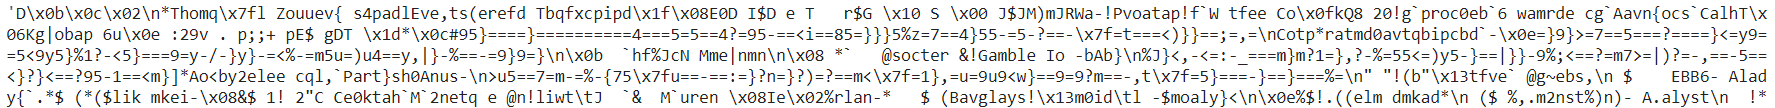

This does not allow to identify any sentiment. Therefore, these documents need to be idetified to then be excluded from the dataset.


In [312]:
def documents_with_err(document_names, documents):
    documents_with_errors = []

    for i,document in enumerate(documents):
      try: 
        get_name(document)
      except IndexError:
        documents_with_errors.append(i)

    document_names = np.delete(document_names, documents_with_errors)
    documents = np.delete(documents, documents_with_errors)
    return document_names, documents

In [313]:
doc_len = len(documents)
document_names, documents = documents_with_err(document_names, documents)
sentence = 'Before dropping the documents containing only random chars, we have {:d} documents, afterwards, we are left with {:d}'.format(doc_len, len(documents))
print(sentence)

Before dropping the documents containing only random chars, we have 1977 documents, afterwards, we are left with 1963


After filtering out only the valid transcripts, we can now execute our main function to create the dataset.

In [315]:
#sentiment_table, qanda_table = create_sentiment_and_qanda_tables(documents)

## 1.9 Missing values

Some of the rows in the sentiment table have only zeros for the tone scores.
To get an better understanding of why this is the case, we look if some this observation is more common among one company. 

Therefore, we print a list with the five companys having most conferences without tone scores.  

---



In [ ]:
sentiment_table.loc[sentiment_table['hen_tone_total'] == 0, 'institute'].value_counts().head(5)

Wal-Mart Stores Inc                     59
Verizon Communications Inc               4
Intel Corp                               4
JPMorgan Chase & Co                      4
International Business Machines Corp     3
Name: institute, dtype: int64

As we can see. Most of these cases are in Wal-Mart Stores Inc transcripts.
By observing the documents, we can see that these transcripts do not have a Q&A section. In our code, we used zero as default value if there are not all sections included in the transcript. 

Since we want to analyze all sections of the transcripts, we drop the 108 rows without any scores.

In [ ]:
before = sentiment_table.shape[0]
to_drop = len(sentiment_table.loc[(sentiment_table['hen_tone_questions'] == 0) & (sentiment_table['hen_tone_answers'] == 0)].index)
sentiment_table = sentiment_table.drop(sentiment_table.loc[(sentiment_table['hen_tone_questions'] == 0) & (sentiment_table['hen_tone_answers'] == 0)].index)
sentence = 'Before dropping the {:d} scores, we have a total of {:d} rows in the table, afterwards we have {:d} rows left.'.format(to_drop, before, sentiment_table.shape[0])
print(sentence)

Before dropping the 5 scores, we have a total of 1855 rows in the table, afterwards we have 1850 rows left.


Now, all the conferences included in the qanda_table should be the same as the conferences in the sentiment_table. To check whether this is the case, we compare the length of both.

In [ ]:
sentence = 'Length of the sentiment_table index ({:d}) is the same as the length of the unique list of conferences in the qanda_table ({:d}): {:b}'.format(len(sentiment_table.index), len(qanda_table['conference'].unique()), len(sentiment_table.index) == len(qanda_table['conference'].unique()))
print(sentence)

Length of the sentiment_table index (1850) is the same as the length of the unique list of conferences in the qanda_table (1851): 0


Since the list has not the same length, we have o search for a conference included in the qanda_table but not in the sentiment_table.

In [ ]:
for index in qanda_table['conference'].unique():
  if index not in sentiment_table.index:
    print(index)
    print(qanda_table.loc[qanda_table['conference'] == index])

AXP-Transcript-2012-01-19T22_00.txt
     person  ...                           conference
0  operator  ...  AXP-Transcript-2012-01-19T22_00.txt

[1 rows x 4 columns]


Since this is the case only for one entry and this enry is only of the operator, we can drop it from the qanda_table

In [ ]:
qanda_table = qanda_table.loc[qanda_table['conference'] != 'AXP-Transcript-2012-01-19T22_00.txt']
sentence = 'Length of the sentiment_table index ({:d}) is the same as the length of the unique list of conferences in the qanda_table ({:d}): {:b}'.format(len(sentiment_table.index), len(qanda_table['conference'].unique()), len(sentiment_table.index) == len(qanda_table['conference'].unique()))
print(sentence)

Length of the sentiment_table index (1850) is the same as the length of the unique list of conferences in the qanda_table (1850): 1


## 1.10 Save the tables

Now we have the tables created and dealt with the missing values.
Therefore, we can now save them to pickles.

In [ ]:
sentiment_table.to_pickle('sentiment_table')

In [ ]:
qanda_table.to_pickle('qanda_table')

# 2 Descriptive Statistics of the Sentiment Values


In [300]:
sentiment_table = pd.read_pickle('sentiment_table')

In [326]:
sentiment_table[['h_tone_total', 'hen_tone_total', 'lm_tone_total']].describe().iloc[:3]

,h_tone_total,hen_tone_total,lm_tone_total
count,1850.000000,1850.000000,1850.000000
mean,0.366252,0.600202,0.283524
std,0.090493,0.165729,0.205050


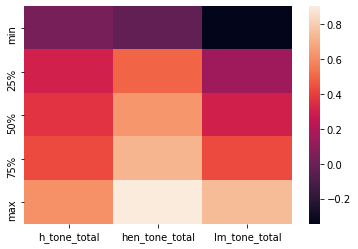

In [293]:
sns.heatmap(sentiment_table[['h_tone_total', 'hen_tone_total', 'lm_tone_total']].describe().iloc[3:])

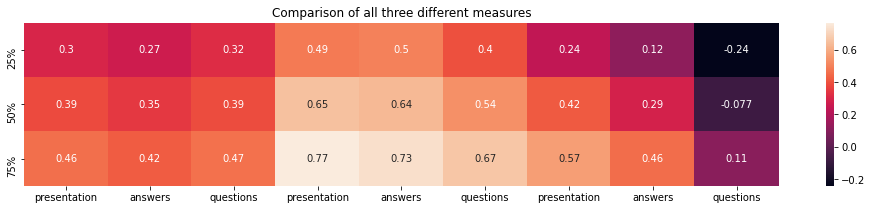

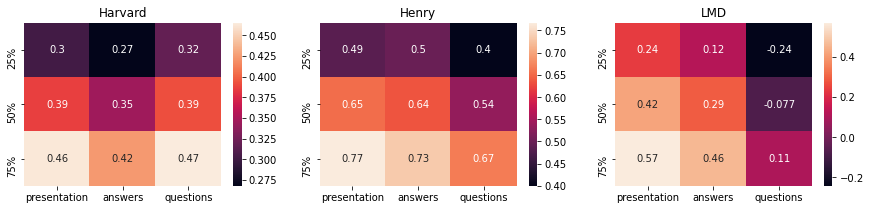

In [291]:
plt.figure(figsize=(16.9,3))
plt.title('Comparison of all three different measures')
sns.heatmap(sentiment_table[['h_tone_presentation', 'h_tone_answers', 'h_tone_questions', 'hen_tone_presentation', 'hen_tone_answers', 'hen_tone_questions', 'lm_tone_presentation', 'lm_tone_answers', 'lm_tone_questions']].describe().iloc[4:-1],annot=True, xticklabels = ['presentation','answers','questions', 'presentation','answers','questions', 'presentation','answers','questions'])

plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.title('Harvard')
sns.heatmap(sentiment_table[['h_tone_presentation', 'h_tone_answers', 'h_tone_questions']].describe().iloc[4:-1],annot=True, xticklabels=['presentation','answers','questions'])

plt.subplot(1,3,2)
plt.title('Henry')
sns.heatmap(sentiment_table[['hen_tone_presentation', 'hen_tone_answers', 'hen_tone_questions']].describe().iloc[4:-1],annot=True, xticklabels=['presentation','answers','questions'])

plt.subplot(1,3,3)
plt.title('LMD')
sns.heatmap(sentiment_table[['lm_tone_presentation', 'lm_tone_answers', 'lm_tone_questions']].describe().iloc[4:-1],annot=True, xticklabels=['presentation','answers','questions'])